In [1]:
import os
from typing import Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import pytorch_lightning as pl
from lightning.pytorch.loggers import CSVLogger
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from torchvision.transforms.functional import rotate

import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    try:
        torch.set_float32_matmul_precision('medium')
    except:
        pass
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(device)

rng = np.random.default_rng()

cuda


In [3]:
v = max(
    [-1] +
    [
        int(j.split('_')[-1])
        for j in 
        [i for i in os.walk(os.path.join(os.getcwd(), 'lightning_logs'))][0][1]
    ]
)

In [4]:
train_dataset = MNIST(
    os.path.join(os.getcwd(), 'Data', 'final_project'),
    train=True,
    download=True,
    transform=ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    num_workers=16,
    persistent_workers=True,
    shuffle=True
)
test_dataset = MNIST(
    os.path.join(os.getcwd(), 'Data', 'final_project'),
    train=False,
    download=True,
    transform=ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    num_workers=16,
    persistent_workers=True,
    shuffle=False
)

In [5]:
def display_results(name: str, v: int) -> float:
    res = read_csv('./lightning_logs/version_' + str(v) + '/metrics.csv')
    res = res[['step', 'epoch', 'train_loss', 'test_loss', 'test_accuracy']]
    
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    if 'Danny' in name:
        if '10' in name:
            info = "Danny's 10-Class"
        else:
            info = "Danny's 2-Class"
    else:
        if '10' in name:
            info = "Xiong et al.'s 10-Class"
        else:
            info = "Xiong et al.'s 2-Class"
    if 'w/ rotation' in name:
        rotation = ' w/ rotation'
    else:
        rotation = ''
    fig.suptitle(f'{info} CNN{rotation}: Theoretical MNIST Performance')
    
    axs[0].plot(
        res.iloc[res.iloc[:,2].dropna().index, 0],
        res.iloc[:,2].dropna(),
        label='Train'
    )
    axs[0].plot(
        res.iloc[res.iloc[:,3].dropna().index, 0],
        res.iloc[:,3].dropna(),
        label='Test',
        c='red'
    )
    axs[0].legend()
    axs[0].set_xlabel('Batch #')
    axs[0].set_ylabel('Cross-Entropy Loss')
    
    axs[1].plot(
        res.iloc[res.iloc[:,4].dropna().index, 1],
        res.iloc[:,4].dropna(),
        label='Test'
    )
    axs[1].scatter(
        res.iloc[-1,1],
        res.iloc[-1,-1],
        s=12,
        c='red',
        label='Final = ' + str(round(res.iloc[-1,-1]*100, 3)) + '%'
    )
    axs[1].legend()
    axs[1].set_xlabel('Epoch #')
    axs[1].set_ylabel('Accuracy')
    
    plt.show(fig)
    
    return res.iloc[-1,-1]

In [6]:
def get_xiong_10class_output(model, x: Tensor) -> Tensor:
        
        x = x.ceil()
        if model.turn:
            degree = int(rng.choice([30*i for i in range(12)]))
            x = rotate(x, degree, fill=0)
 
        x = F.relu(model.conv1(x))
                
        out = F.softmax(x.flatten(start_dim=1), dim=1)       
        return out
        

class xiong10class(pl.LightningModule):
    def __init__(self, turn: bool) -> None:
        super().__init__()

        self.turn = turn
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=(6,14),
            stride=(5,14),
            padding=0,
            padding_mode='zeros',
            bias=False,
        )
  

    def training_step(self, batch: Tensor) -> Tensor:
        x, y = batch
        
        out = get_xiong_10class_output(self, x)

        loss = F.cross_entropy(out, y.squeeze())
        self.log('train_loss', loss, batch_size=train_loader.batch_size)
        return loss
    
    
    def validation_step(self, batch: Tensor) -> Tensor:
        x, y = batch

        out = get_xiong_10class_output(self, x)
        
        loss = F.cross_entropy(out, y.squeeze())
        self.log('test_loss', loss, batch_size=test_loader.batch_size)
        acc = (torch.max(out, dim=1)[1] == y).to(torch.float32).mean()
        self.log(
            'test_accuracy',
            acc,
            on_epoch=True,
            batch_size=test_loader.batch_size
        )
        return loss
    
    
    def configure_optimizers(self):
        if device == 'cuda':
            fused = True
        else:
            fused = False
        optimizer = optim.Adam(self.parameters(), lr=1e-2, fused=fused)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        return {
            'optimizer': optimizer,
            'lr_scheduler':scheduler,
            'monitor':'test_accuracy'
        }

In [7]:
def get_xiong_2class_output(model, x: Tensor) -> Tensor:
        
        x = x.ceil()
        if model.turn:
            degree = int(rng.choice([30*i for i in range(12)]))
            x = rotate(x, degree, fill=0)
 
        x = F.relu(model.conv1(x))
        x = model.pool1(x)
                
        out = F.softmax(x.flatten(start_dim=1), dim=1)       
        return out
        

class xiong2class(pl.LightningModule):
    def __init__(self, turn: bool) -> None:
        super().__init__()

        self.turn = turn
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=(14,14),
            stride=(14,14),
            padding=0,
            padding_mode='zeros',
            bias=False,
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=(2,1))
     
    
    def training_step(self, batch: Tensor) -> Tensor:
        x, y = batch
        
        out = get_xiong_2class_output(self, x)

        y = (
            (y == 0) + (y == 2) + (y == 3) + (y == 6) + (y == 8)
        ).to(torch.int64)
        
        loss = F.cross_entropy(out, y.squeeze())
        self.log('train_loss', loss, batch_size=train_loader.batch_size)
        return loss
    
    
    def validation_step(self, batch: Tensor) -> Tensor:
        x, y = batch

        out = get_xiong_2class_output(self, x)
        
        y = (
            (y == 0) + (y == 2) + (y == 3) + (y == 6) + (y == 8)
        ).to(torch.int64)
        
        loss = F.cross_entropy(out, y.squeeze())
        self.log('test_loss', loss, batch_size=test_loader.batch_size)
        acc = (torch.max(out, dim=1)[1] == y).to(torch.float32).mean()
        self.log(
            'test_accuracy',
            acc,
            on_epoch=True,
            batch_size=test_loader.batch_size
        )
        return loss
    
    
    def configure_optimizers(self):
        if device == 'cuda':
            fused = True
        else:
            fused = False
        optimizer = optim.Adam(self.parameters(), lr=1e-2, fused=fused)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        return {
            'optimizer': optimizer,
            'lr_scheduler':scheduler,
            'monitor':'test_accuracy'
        }

In [8]:
def get_danny_10class_output(model, x: Tensor) -> Tensor:
        
        x = x.ceil()
        if model.turn:
            degree = int(rng.choice([30*i for i in range(12)]))
            x = rotate(x, degree, fill=0)
        
        r0 = model.res0(x)
        x1 = (F.tanh(model.conv1(x)) + 1) / 2
        r1 = model.res1(x1)
        x1 = model.pool1(x1)
        x2 = (F.tanh(model.conv2(x1)) + 1) / 2
        r2 = model.res2(x2)
        
        out1 = (
            F.tanh(
                model.linear_out1(
                    torch.cat(
                        [
                            r0.flatten(start_dim=1),
                            r1.flatten(start_dim=1),
                            r2.flatten(start_dim=1),
                        ],
                        axis=1
                    )
                )
            )
            + 1
        ) / 2
        
        out2 = (F.tanh(model.linear_out2(out1)) + 1) / 2
        out3 = model.linear_out3(torch.cat([out1, out2], axis=1))
        
        out = F.softmax(out3, dim=1)       
        return out
        

class danny10class(pl.LightningModule):
    def __init__(self, turn: bool) -> None:
        super().__init__()
        
        self.turn = turn

        self.res0 = nn.AvgPool2d(kernel_size=9) # 3x3=9
        
        self.conv1 = nn.Conv2d( # 28x28 -> 26x26
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=0,
            padding_mode='zeros',
            bias=True,
        )
        
        self.res1 = nn.AvgPool2d(kernel_size=8) # 3x3=9
        
        self.pool1 = nn.AvgPool2d(kernel_size=2) # 26x26 -> 13x13
                        
        self.conv2 = nn.Conv2d( # 13x13 -> 11x11
            in_channels=self.conv1.out_channels,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=0,
            padding_mode='zeros',
            bias=True,
        )
        
        self.res2 = nn.AvgPool2d(kernel_size=3) # 3x3=9
        
        self.linear_out1 = nn.Linear(
            in_features=27,
            out_features=3
        )
        
        self.linear_out2 = nn.Linear(
            in_features=self.linear_out1.out_features,
            out_features=3
        )
        
        self.linear_out3 = nn.Linear(
            in_features=(
                self.linear_out2.out_features + self.linear_out1.out_features
            ),
            out_features=10
        )
                
    
    def training_step(self, batch: Tensor,) -> Tensor:
        x, y = batch
        
        out = get_danny_10class_output(self, x)
        
        loss = F.cross_entropy(out, y.squeeze())
        self.log('train_loss', loss, batch_size=train_loader.batch_size)
        return loss
    
    
    def validation_step(self, batch: Tensor) -> Tensor:
        x, y = batch

        out = get_danny_10class_output(self, x)
        
        loss = F.cross_entropy(out, y.squeeze())
        self.log('test_loss', loss, batch_size=test_loader.batch_size)
        acc = (torch.max(out, dim=1)[1] == y).to(torch.float32).mean()
        self.log(
            'test_accuracy',
            acc,
            on_epoch=True,
            batch_size=test_loader.batch_size
        )
        return loss
    
    
    def configure_optimizers(self):
        if device == 'cuda':
            fused = True
        else:
            fused = False
        optimizer = optim.Adam(self.parameters(), lr=1e-1, fused=fused)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        return {
            'optimizer': optimizer,
            'lr_scheduler':scheduler,
            'monitor':'test_accuracy'
        }

In [9]:
def get_danny_2class_output(model, x: Tensor) -> Tensor:
        
        x = x.ceil()
        if model.turn:
            degree = int(rng.choice([30*i for i in range(12)]))
            x = rotate(x, degree, fill=0)
        
        r0 = model.res0(x)
        x1 = (F.tanh(model.conv1(x)) + 1) / 2
        r1 = model.res1(x1)
        x1 = model.pool1(x1)
        x2 = (F.tanh(model.conv2(x1)) + 1) / 2
        r2 = model.res2(x2)
        
        out1 = (
            F.tanh(
                model.linear_out1(
                    torch.cat(
                        [
                            r0.flatten(start_dim=1),
                            r1.flatten(start_dim=1),
                            r2.flatten(start_dim=1),
                        ],
                        axis=1
                    )
                )
            )
            + 1
        ) / 2
        
        out2 = (F.tanh(model.linear_out2(out1)) + 1) / 2
        out3 = model.linear_out3(torch.cat([out1, out2], axis=1))
        
        out = F.softmax(out3, dim=1)       
        return out
        

class danny2class(pl.LightningModule):
    def __init__(self, turn: bool) -> None:
        super().__init__()
        
        self.turn = turn

        self.res0 = nn.AvgPool2d(kernel_size=9) # 3x3=9
        
        self.conv1 = nn.Conv2d( # 28x28 -> 26x26
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=0,
            padding_mode='zeros',
            bias=True,
        )
        
        self.res1 = nn.AvgPool2d(kernel_size=8) # 3x3=9
        
        self.pool1 = nn.AvgPool2d(kernel_size=2) # 26x26 -> 13x13
                        
        self.conv2 = nn.Conv2d( # 13x13 -> 11x11
            in_channels=self.conv1.out_channels,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=0,
            padding_mode='zeros',
            bias=True,
        )
        
        self.res2 = nn.AvgPool2d(kernel_size=3) # 3x3=9
        
        self.linear_out1 = nn.Linear(
            in_features=27,
            out_features=3
        )
        
        self.linear_out2 = nn.Linear(
            in_features=self.linear_out1.out_features,
            out_features=3
        )
        
        self.linear_out3 = nn.Linear(
            in_features=(
                self.linear_out2.out_features + self.linear_out1.out_features
            ),
            out_features=2
        )
                
    
    def training_step(self, batch: Tensor,) -> Tensor:
        x, y = batch
        
        out = get_danny_2class_output(self, x)
        
        y = (
            (y == 0) + (y == 2) + (y == 3) + (y == 6) + (y == 8)
        ).to(torch.int64)
        
        loss = F.cross_entropy(out, y.squeeze())
        self.log('train_loss', loss, batch_size=train_loader.batch_size)
        return loss
    
    
    def validation_step(self, batch: Tensor) -> Tensor:
        x, y = batch

        out = get_danny_2class_output(self, x)
        
        y = (
            (y == 0) + (y == 2) + (y == 3) + (y == 6) + (y == 8)
        ).to(torch.int64)
        
        loss = F.cross_entropy(out, y.squeeze())
        self.log('test_loss', loss, batch_size=test_loader.batch_size)
        acc = (torch.max(out, dim=1)[1] == y).to(torch.float32).mean()
        self.log(
            'test_accuracy',
            acc,
            on_epoch=True,
            batch_size=test_loader.batch_size
        )
        return loss
    
    
    def configure_optimizers(self):
        if device == 'cuda':
            fused = True
        else:
            fused = False
        optimizer = optim.Adam(self.parameters(), lr=1e-1, fused=fused)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        return {
            'optimizer': optimizer,
            'lr_scheduler':scheduler,
            'monitor':'test_accuracy'
        }

In [10]:
model_list = [
    ('Danny 10-class', danny10class(turn=False).to(device=device)),
    ('Danny 10-class w/ rotation', danny10class(turn=True).to(device=device)),
    ('Danny 2-class', danny2class(turn=False).to(device=device)),
    ('Danny 2-class w/ rotation', danny2class(turn=True).to(device=device)),
    ('Xiong 10-class', xiong10class(turn=False).to(device=device)),
    ('Xiong 10-class w/ rotation', xiong10class(turn=True).to(device=device)),
    ('Xiong 2-class', xiong2class(turn=False).to(device=device)),
    ('Xiong 2-class w/ rotation', xiong2class(turn=True).to(device=device)),
]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | res0        | AvgPool2d | 0     
1 | conv1       | Conv2d    | 10    
2 | res1        | AvgPool2d | 0     
3 | pool1       | AvgPool2d | 0     
4 | conv2       | Conv2d    | 10    
5 | res2        | AvgPool2d | 0     
6 | linear_out1 | Linear    | 84    
7 | linear_out2 | Linear    | 12    
8 | linear_out3 | Linear    | 70    
------------------------------------------
186       Trainable params
0         Non-trainable params
186       Total params
0.001     Total estimated model params size (MB)


v = 33	Danny 10-class
Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 130.27it/s, v_num=33]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 129.83it/s, v_num=33]


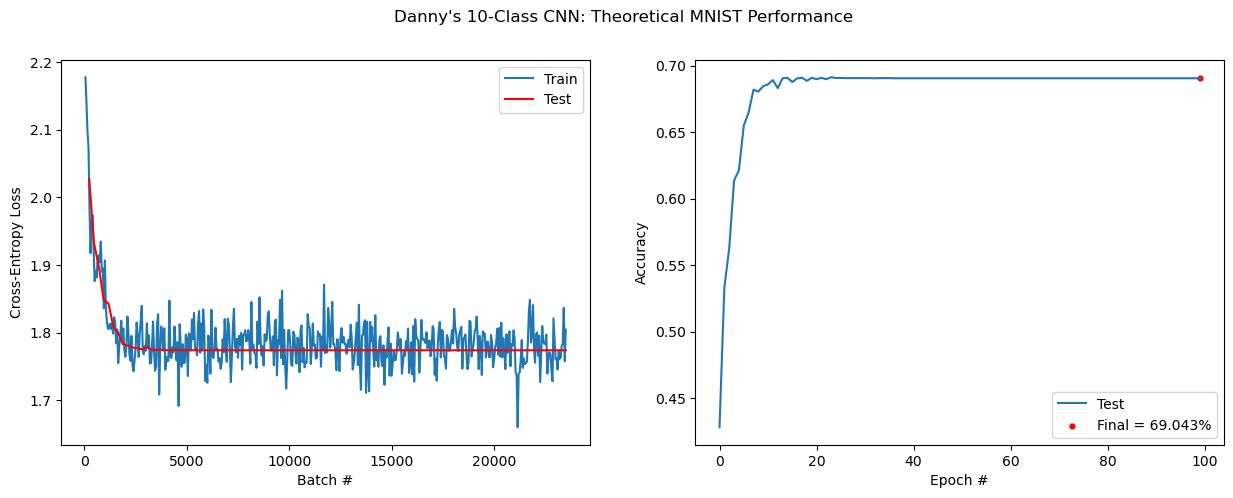

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | res0        | AvgPool2d | 0     
1 | conv1       | Conv2d    | 10    
2 | res1        | AvgPool2d | 0     
3 | pool1       | AvgPool2d | 0     
4 | conv2       | Conv2d    | 10    
5 | res2        | AvgPool2d | 0     
6 | linear_out1 | Linear    | 84    
7 | linear_out2 | Linear    | 12    
8 | linear_out3 | Linear    | 70    
------------------------------------------
186       Trainable params
0         Non-trainable params
186       Total params
0.001     Total estimated model params size (MB)


v = 34	Danny 10-class w/ rotation
Epoch 99: 100%|██████████| 235/235 [00:02<00:00, 105.51it/s, v_num=34]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:02<00:00, 105.20it/s, v_num=34]


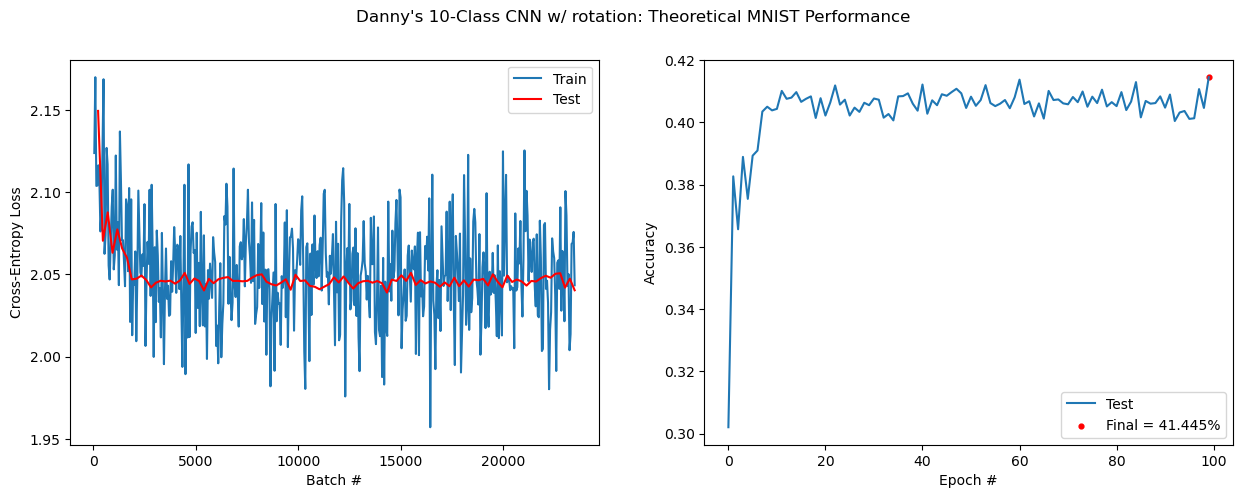

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | res0        | AvgPool2d | 0     
1 | conv1       | Conv2d    | 10    
2 | res1        | AvgPool2d | 0     
3 | pool1       | AvgPool2d | 0     
4 | conv2       | Conv2d    | 10    
5 | res2        | AvgPool2d | 0     
6 | linear_out1 | Linear    | 84    
7 | linear_out2 | Linear    | 12    
8 | linear_out3 | Linear    | 14    
------------------------------------------
130       Trainable params
0         Non-trainable params
130       Total params
0.001     Total estimated model params size (MB)


v = 35	Danny 2-class
Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 119.28it/s, v_num=35]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 118.98it/s, v_num=35]


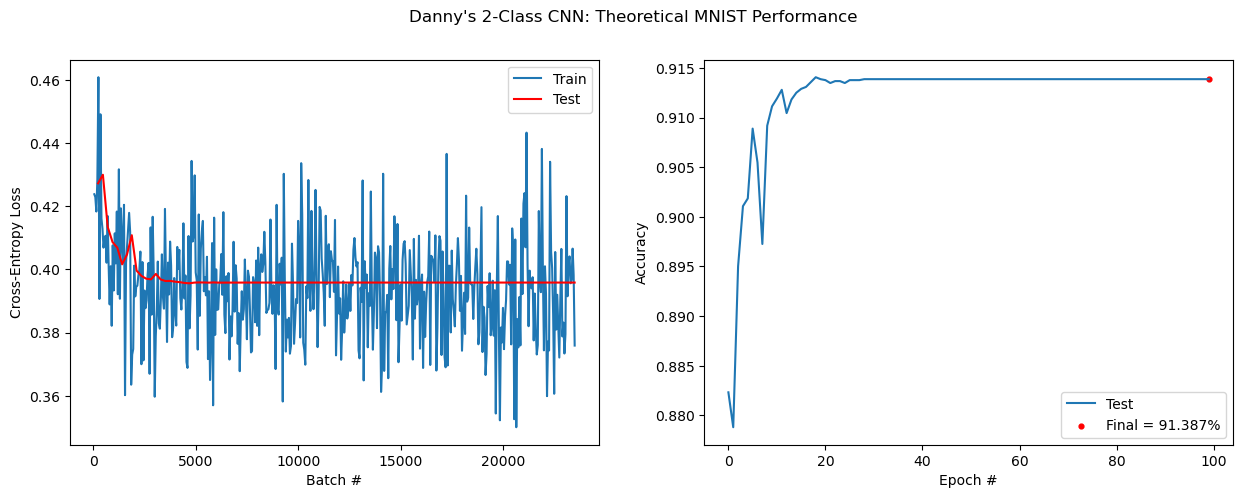

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | res0        | AvgPool2d | 0     
1 | conv1       | Conv2d    | 10    
2 | res1        | AvgPool2d | 0     
3 | pool1       | AvgPool2d | 0     
4 | conv2       | Conv2d    | 10    
5 | res2        | AvgPool2d | 0     
6 | linear_out1 | Linear    | 84    
7 | linear_out2 | Linear    | 12    
8 | linear_out3 | Linear    | 14    
------------------------------------------
130       Trainable params
0         Non-trainable params
130       Total params
0.001     Total estimated model params size (MB)


v = 36	Danny 2-class w/ rotation
Epoch 99: 100%|██████████| 235/235 [00:02<00:00, 98.90it/s, v_num=36]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:02<00:00, 98.69it/s, v_num=36]


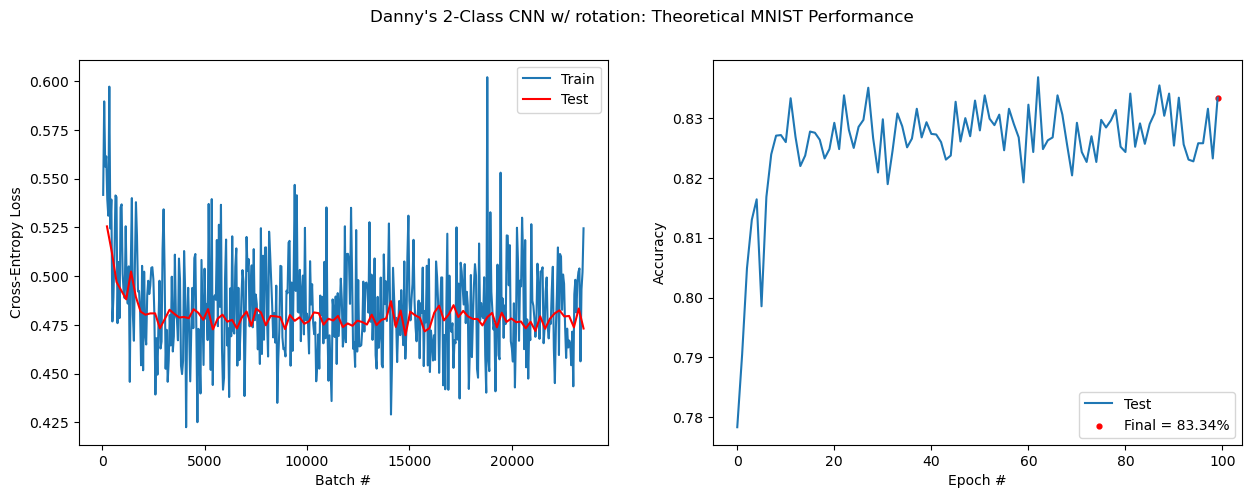

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 84    
---------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)


v = 37	Xiong 10-class
Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 155.20it/s, v_num=37]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 154.68it/s, v_num=37]


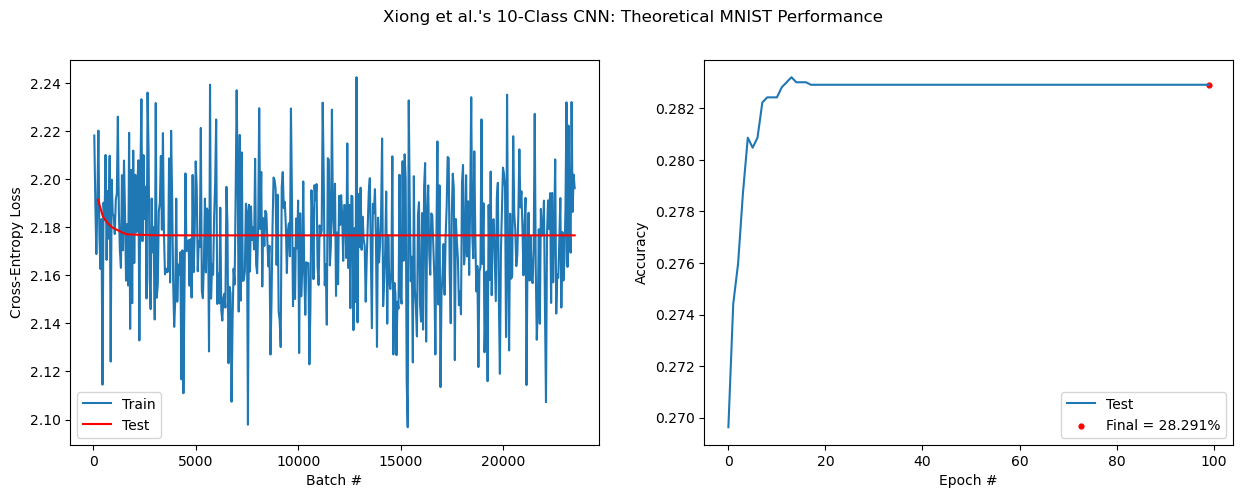

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 84    
---------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)


v = 38	Xiong 10-class w/ rotation
Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 119.11it/s, v_num=38]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 118.87it/s, v_num=38]


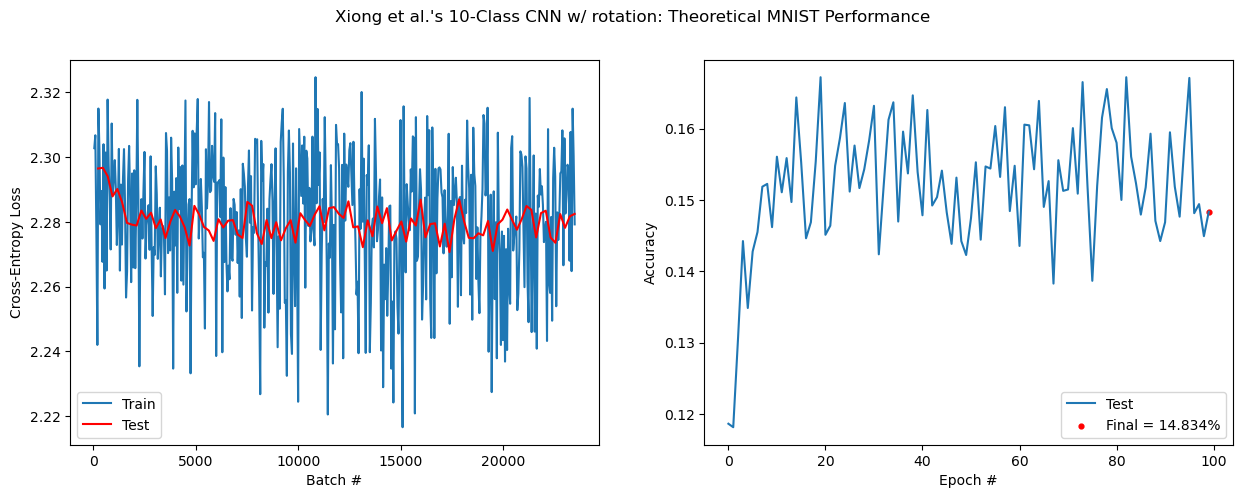

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 196   
1 | pool1 | MaxPool2d | 0     
------------------------------------
196       Trainable params
0         Non-trainable params
196       Total params
0.001     Total estimated model params size (MB)


v = 39	Xiong 2-class
Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 139.57it/s, v_num=39]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:01<00:00, 139.32it/s, v_num=39]


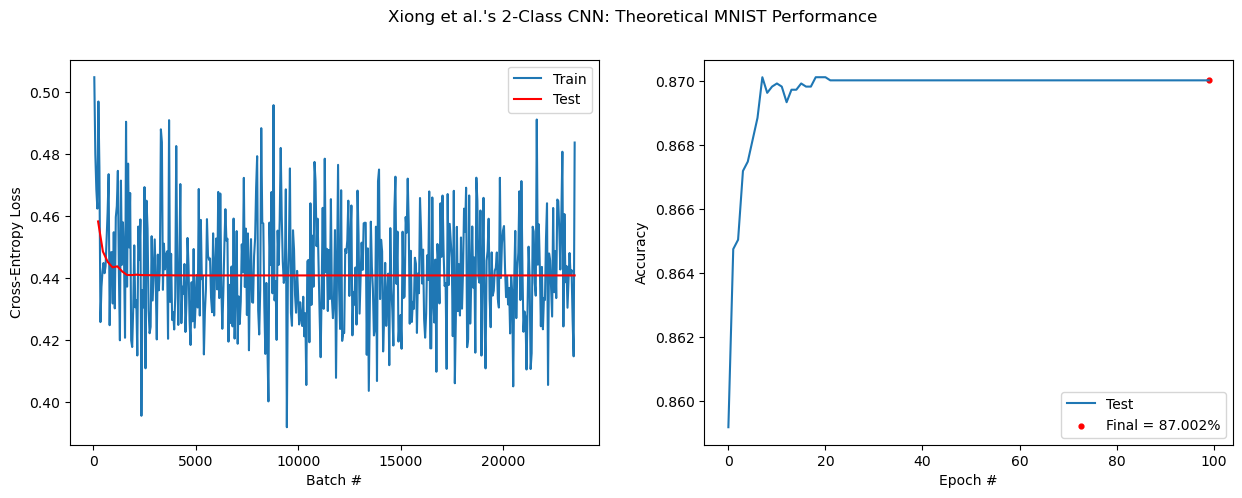

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 196   
1 | pool1 | MaxPool2d | 0     
------------------------------------
196       Trainable params
0         Non-trainable params
196       Total params
0.001     Total estimated model params size (MB)


v = 40	Xiong 2-class w/ rotation
Epoch 99: 100%|██████████| 235/235 [00:02<00:00, 113.60it/s, v_num=40]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 235/235 [00:02<00:00, 113.38it/s, v_num=40]


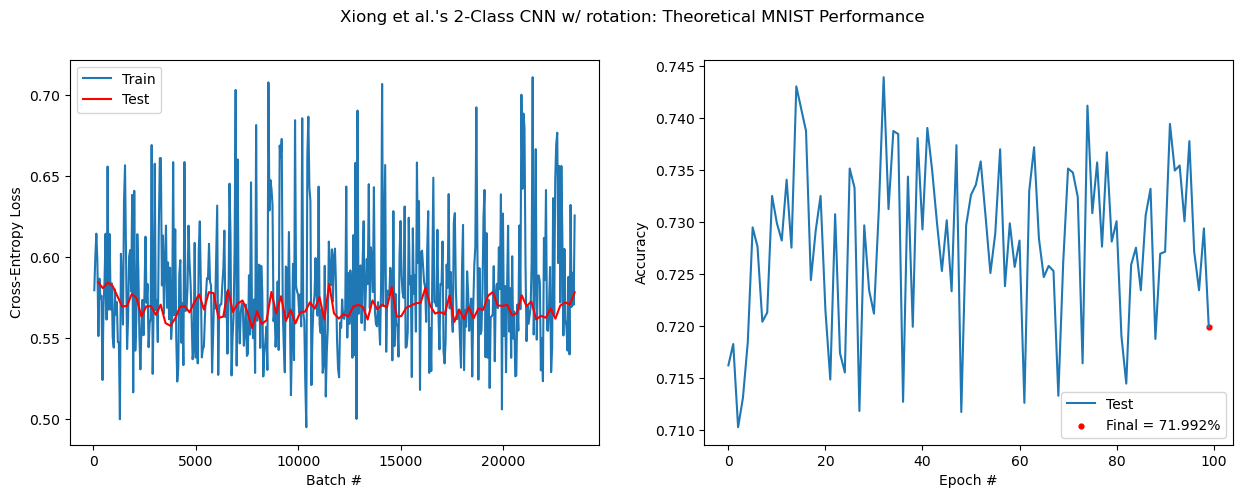


Danny 10-class Test Accuracy: 0.6904296875

Danny 10-class w/ rotation Test Accuracy: 0.4144531190395355

Danny 2-class Test Accuracy: 0.913867175579071

Danny 2-class w/ rotation Test Accuracy: 0.8333984613418579

Xiong 10-class Test Accuracy: 0.2829101681709289

Xiong 10-class w/ rotation Test Accuracy: 0.1483398377895355

Xiong 2-class Test Accuracy: 0.8700195550918579

Xiong 2-class w/ rotation Test Accuracy: 0.719921886920929


In [11]:
res = []

for name, model_instance in model_list:
    v += 1
    print('v = ' + str(v) + '\t' + name)
    
    if '10' in name:
        epochs = 100
    else:
        epochs = 100
    
    trainer = pl.Trainer(
        limit_train_batches=60000,
        max_epochs=epochs,
        limit_val_batches=10000,
        precision='32',
        logger=CSVLogger(os.getcwd())
    )
    trainer.fit(
        model=model_instance,
        train_dataloaders=train_loader,
        val_dataloaders=test_loader,
    )
    
    res.append((name, display_results(name=name, v=v)))

for name, val in res:
    print(f'\n{name} Test Accuracy: {val}')